In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
from torch.autograd import Variable as V

# Data generation

Let's create our tasks for sine, square, and triangle waves and potential noise in training sets.

In [2]:
class Wave:
    def __init__(self, K, noise_percent):
        # K as in K-shot learning
        self.amp = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, np.pi)
        self.K = K
        self.noise_percent = noise_percent
        self.mini_train = None
        self.mini_test = None
        
    def mini_train_set(self):
        if self.mini_train is None:
            x = np.random.uniform(-5, 5, (self.K, 1))
            y = self.f(x) + np.random.normal(0, self.noise_percent*self.amp, (self.K, 1))
            self.mini_train=(x,y)
        return torch.Tensor(self.mini_train[0]), torch.Tensor(self.mini_train[1])
    
    def mini_test_set(self):
        self.mini_test = x = np.random.uniform(-5, 5, (self.K, 1))
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def eval_set(self, size=50):
        x = np.linspace(-5, 5, size).reshape((size, 1))
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
class SineWave(Wave):
    def __init__(self, K = 10, noise_percent = 0):
        super().__init__(K,noise_percent)

    def f(self, x):
        return self.amp * np.sin(x + self.phase)
    
class SquareWave(Wave):
    def __init__(self, K = 10, noise_percent = 0):
        super().__init__(K, noise_percent)

    def f(self, x):
        return self.amp * sp.square(x + self.phase)
    
class SawtoothWave(Wave):
    def __init__(self, K = 10, noise_percent = 0):
        super().__init__(K, noise_percent)

    def f(self, x):
        return self.amp * sp.sawtooth(x + self.phase)

In [3]:
class DataGenerator:
    def __init__(self, function, size=50000, K = 10, noise_percent=0):
        self.size = size
        self.K = K
        self.function = function
        self.noise_percent = noise_percent
        self.tasks = None 
        
    def generate_set(self):
        config = {"sine" : SineWave, "square" : SquareWave, "sawtooth" : SawtoothWave}
        self.tasks = tasks = [config[self.function](self.K, self.noise_percent) for _ in range(self.size)]
        return tasks
    
    def shuffled_set(self):
        if self.tasks is None:
            self.generate_set()
        return random.sample(self.tasks, len(self.tasks))

# Model creation

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(1, 40)
        self.hidden2 = nn.Linear(40, 40)
        self.out = nn.Linear(40, 1)
    
    def set_attr(self, name, param):
        #BIGGEST HACK EVER.. 
        if name == "hidden1.weight":
            self.hidden1.weight = param
        if name == "hidden1.bias":
            self.hidden1.bias = param    
        if name == "hidden2.weight":
            self.hidden2.weight = param
        if name == "hidden2.bias":
            self.hidden2.bias = param    
        if name == "out.weight":
            self.out.weight = param
        if name == "out.bias":
            self.out.bias = param    
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)

# Reptile Meta-Learning Algorithm

In [47]:
class MetaLearner():
    def __init__(self, higher_order=False, lr_inner=0.01, lr_outer=0.001, sgd_steps_inner=10):
        self.lr_inner = lr_inner
        self.lr_outer = lr_outer
        self.sgd_steps_inner = sgd_steps_inner
        self.higher_order = higher_order
        
    def inner_train(self, model, task, optimizer):
        optimizer.zero_grad()
        x, y = task.mini_train_set()
        predicted = model(x)
        loss = F.mse_loss(predicted, y)
        loss.backward()
        optimizer.step()
    
    def init_grad(self, model):
        for param in model.parameters():
            param.grad = torch.zeros_like(param)
        
class Reptile(MetaLearner):
    def __init__(self, lr_inner=0.01, lr_outer=0.001, sgd_steps_inner=10):
        super().__init__(False, lr_inner, lr_outer, sgd_steps_inner)
        
    def compute_store_gradients(self, target, current):
        current_weights = dict(current.named_parameters())
        target_weights = dict(target.named_parameters())
        gradients = {name: (current_weights[name].data - target_weights[name].data) / (self.sgd_steps_inner * self.lr_inner) for name in target_weights}

        for name in current_weights:
            current_weights[name].grad.data = gradients[name]

    def train(self, model, train_data):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr_outer)
        self.init_grad(model)

        for i, task in enumerate(train_data.shuffled_set()):
            optimizer.zero_grad()

            inner_model = copy.deepcopy(model)
            inner_optim = torch.optim.SGD(inner_model.parameters(), lr=self.lr_inner)

            for _ in range(self.sgd_steps_inner):
                self.inner_train(inner_model, task, inner_optim)

            self.compute_store_gradients(inner_model, model)
            optimizer.step()

            if i % 5000 == 0:
                print("iteration:", i)

In [116]:
reptile_model = Net()
reptile_learning_alg = Reptile()
train_data = DataGenerator("sine")
reptile_learning_alg.train(reptile_model, train_data)


iteration: 0
iteration: 5000
iteration: 10000
iteration: 15000
iteration: 20000
iteration: 25000
iteration: 30000
iteration: 35000
iteration: 40000
iteration: 45000


In [7]:
def inner_train(model, task, optimizer):
    optimizer.zero_grad()
    x, y = task.mini_train_set()
    predicted = model(x)
    loss = F.mse_loss(predicted, y)
    loss.backward()
    optimizer.step()

def eval(model):
    test_task = SineWave()
#     xtest, ytest = test.mini_test_set()
    xeval, yeval = test_task.eval_set(size=100)

    model = copy.deepcopy(model)
    optim = torch.optim.SGD(model.parameters(), lr=0.01)
    losses = []
    
    for i in range(10):
        inner_train(model, test_task, optim)
        predicted = model(xeval)
        losses.append(F.mse_loss(predicted, yeval).item())
    
    xplot = xeval.numpy()
    yplot = yeval.numpy()
    predicted_plot = predicted.detach().numpy()
    
    plt.plot(xplot, yplot, 'g', label="ground truth")
    plt.plot(xplot, predicted_plot, 'r', label="predicted")
    plt.show()
    
    plt.plot(losses)
    plt.show()


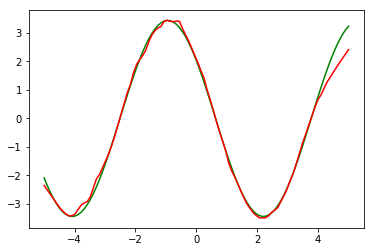

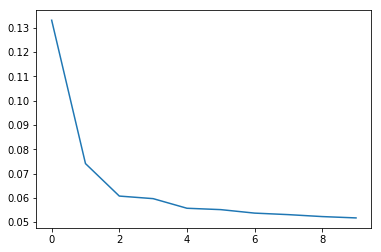

In [118]:
eval(reptile_model)

# MAML

In [39]:
class MAML(MetaLearner):
    def __init__(self, lr_inner=0.01, lr_outer=0.001, sgd_steps_inner=1):
        super().__init__(True, lr_inner, lr_outer, sgd_steps_inner)
        
    def inner_train(self, model, task):
        x, y = task.mini_train_set()
        predicted = model(x)
        loss = F.mse_loss(predicted, y)
        loss.backward(create_graph=True, retain_graph=True)
# #         grads = torch.autograd.grad(loss, model.parameters(), create_graph=True, retain_graph=True)
#         for (name, param), grad in zip(model.named_parameters(), grads):
#             model.set_attr(name, torch.nn.Parameter(param - self.lr_inner * grad))
            
    def train(self, model, train_data):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr_outer)
        self.init_grad(model)

        for i, task in enumerate(train_data.shuffled_set()):
            inner_model = Net()

            for name, param in model.named_parameters():
                inner_model.set_attr(name, param)
                
            for _ in range(self.sgd_steps_inner): 
                self.inner_train(inner_model, task)
                for name, param in inner_model.named_parameters():
#                     if i % 5000 == 0:
#                         print(param.grad)
                    inner_model.set_attr(name, torch.nn.Parameter(param - self.lr_inner * param.grad))

            x, y = task.mini_test_set()
            predicted = inner_model(x)
            loss = F.mse_loss(predicted, y)
            loss.backward(retain_graph=True)
            if i % 5000 == 0:
                print("iteration:", i)
                for name, param in model.named_parameters():
                    print(param.grad.data)
                eval(model)
            optimizer.step()
            optimizer.zero_grad()



iteration: 0
tensor([[ 0.0552],
        [-0.0148],
        [-0.0008],
        [-0.0374],
        [ 0.0075],
        [ 0.0990],
        [-0.0049],
        [-0.0614],
        [-0.0018],
        [ 0.0245],
        [-0.0554],
        [-0.0378],
        [ 0.0379],
        [ 0.0000],
        [-0.0180],
        [ 0.0012],
        [ 0.0076],
        [ 0.0592],
        [ 0.0581],
        [ 0.0066],
        [ 0.0000],
        [-0.0575],
        [-0.0344],
        [-0.0070],
        [ 0.0335],
        [ 0.0000],
        [ 0.0201],
        [ 0.0248],
        [-0.0293],
        [ 0.0577],
        [-0.0183],
        [-0.0715],
        [ 0.0454],
        [ 0.0848],
        [ 0.1344],
        [ 0.0820],
        [ 0.0202],
        [ 0.0928],
        [ 0.0267],
        [ 0.0394]])
tensor([ 0.0055,  0.0223,  0.0004,  0.0050, -0.0197, -0.0465, -0.0206, -0.0240,
         0.0118,  0.0190,  0.0201,  0.0569,  0.0130,  0.0000, -0.0268, -0.0119,
        -0.0283, -0.0264,  0.0071,  0.0150,  0.0000, -0.0022, -0.0

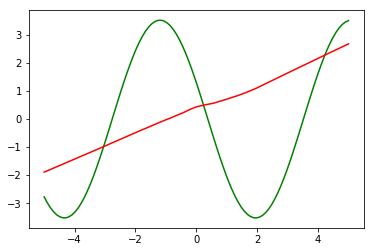

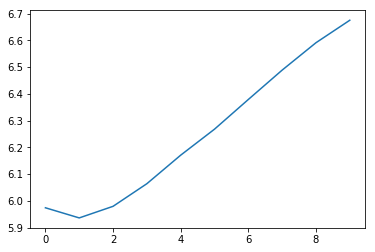

iteration: 5000
tensor([[ 0.1368],
        [ 1.4819],
        [-0.4434],
        [ 0.6289],
        [ 0.3255],
        [ 2.8143],
        [-0.1109],
        [ 0.5518],
        [ 1.6077],
        [ 0.1736],
        [ 0.6086],
        [ 0.3526],
        [-5.2165],
        [ 0.0000],
        [ 0.5090],
        [ 0.1173],
        [ 1.1067],
        [-0.9331],
        [-0.4393],
        [ 0.3087],
        [-6.8966],
        [ 0.3594],
        [ 0.8578],
        [-0.6287],
        [ 0.2095],
        [ 0.0000],
        [-1.0769],
        [ 0.3119],
        [-0.3257],
        [-0.4381],
        [ 0.5709],
        [ 1.3110],
        [-0.5602],
        [ 0.5148],
        [-4.3359],
        [-4.2253],
        [-0.0948],
        [-0.9169],
        [-0.5428],
        [-0.3648]])
tensor([ 0.0101, -0.1931, -0.1759,  0.0456,  0.0351, -0.1148,  0.0306,  0.0842,
        -0.2010, -0.0136,  0.0836, -0.0927, -1.0989,  0.0000,  0.0487,  0.0449,
        -0.0437,  0.2582,  0.1840, -0.0699, -1.4528, -0.0889,  

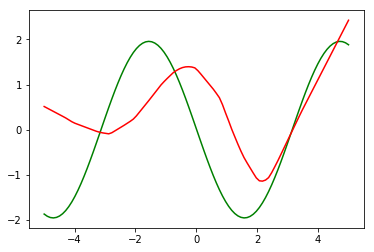

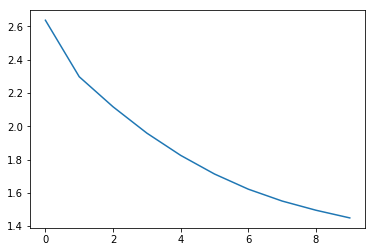

iteration: 10000
tensor([[-5.7383e-02],
        [ 9.6575e-02],
        [-4.3296e-01],
        [ 3.8946e-01],
        [-9.4126e-03],
        [ 6.0719e-01],
        [-4.4565e-03],
        [ 6.6634e-03],
        [ 4.9366e-01],
        [-1.4920e-01],
        [ 1.1144e-02],
        [-8.9702e-03],
        [-1.7741e+00],
        [ 0.0000e+00],
        [ 3.6535e-01],
        [-3.9741e-02],
        [ 4.7129e-01],
        [ 4.7585e-02],
        [-5.0445e-03],
        [ 8.1012e-02],
        [-2.1253e+00],
        [-3.6258e-02],
        [-1.0671e-01],
        [-2.4104e-03],
        [-6.5849e-02],
        [ 0.0000e+00],
        [ 6.6171e-02],
        [ 2.1033e-01],
        [-5.3897e-01],
        [-3.4646e-01],
        [-4.4137e-02],
        [ 6.8478e-01],
        [-2.7784e-02],
        [ 3.8071e-01],
        [-1.4637e+00],
        [-1.4015e+00],
        [-2.5597e-02],
        [-5.2368e-01],
        [-4.8457e-02],
        [-4.7838e-04]])
tensor([-3.4472e-02,  3.9613e-02, -1.9069e-01,  8.8179e-02, -3

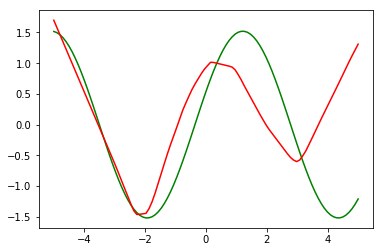

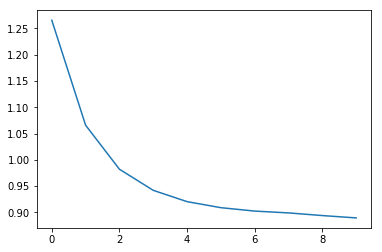

iteration: 15000
tensor([[-0.0092],
        [-0.7939],
        [-0.0312],
        [ 0.0850],
        [ 0.0359],
        [-0.9726],
        [ 0.0491],
        [ 0.0466],
        [-0.6552],
        [ 0.0214],
        [ 0.0462],
        [-0.2303],
        [-0.6739],
        [ 0.0000],
        [ 0.1316],
        [-0.1592],
        [-0.6045],
        [ 0.6880],
        [ 0.2492],
        [-0.1415],
        [-0.7833],
        [-0.1808],
        [ 0.0992],
        [ 0.3672],
        [ 0.0332],
        [ 0.0000],
        [ 0.8196],
        [-0.7049],
        [-0.0475],
        [-0.0368],
        [-0.4063],
        [-0.6639],
        [ 0.2476],
        [ 0.1778],
        [-0.5622],
        [-0.5418],
        [ 0.0061],
        [-0.1086],
        [ 0.3240],
        [ 0.1974]])
tensor([-2.2322e-03,  2.2255e-01, -7.5391e-03,  2.6597e-02, -1.7122e-03,
         3.6707e-01, -1.0296e-02,  2.3843e-03,  2.5215e-01,  5.1729e-03,
        -1.7515e-03,  5.6865e-02, -1.6287e-01,  0.0000e+00,  3.4342e-04,
   

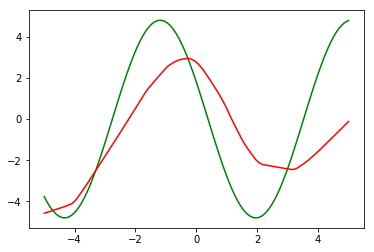

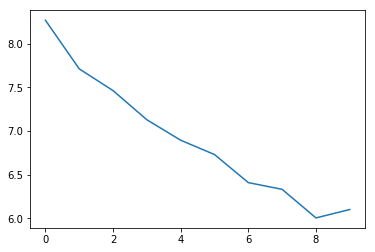

iteration: 20000
tensor([[ 0.0000],
        [-0.2028],
        [-0.1191],
        [-0.9659],
        [-0.4029],
        [-0.2307],
        [ 0.0329],
        [-0.3974],
        [-0.4129],
        [-0.0607],
        [-0.0598],
        [ 0.0356],
        [ 0.8878],
        [ 0.0000],
        [-0.9960],
        [ 0.1746],
        [ 0.9430],
        [-0.4118],
        [-0.0597],
        [ 0.0874],
        [ 1.0059],
        [ 0.2735],
        [-0.1988],
        [-0.1169],
        [-0.1470],
        [ 0.0000],
        [-0.5904],
        [-0.7976],
        [ 0.2321],
        [-0.0311],
        [ 0.3096],
        [ 1.0581],
        [ 0.0649],
        [-0.9707],
        [ 0.7522],
        [ 0.6556],
        [ 0.0771],
        [ 0.1852],
        [ 0.0713],
        [ 0.0626]])
tensor([ 0.0000, -0.2423, -0.0369, -0.2207, -0.0577, -0.9234, -0.0129, -0.0565,
        -0.8305,  0.0887,  0.0858, -0.0689,  0.2571,  0.0000, -0.2613, -0.0628,
        -0.2685,  0.1258,  0.0123, -0.2431,  0.2913, -0.3195, 

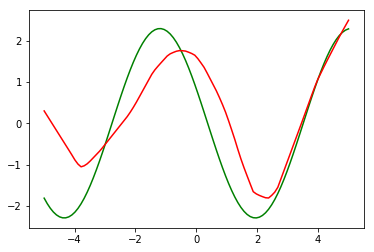

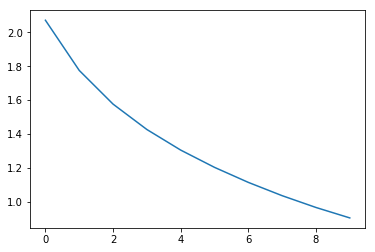

iteration: 25000
tensor([[ 0.0000],
        [-0.1150],
        [ 0.3221],
        [-0.3445],
        [ 0.0434],
        [-0.5011],
        [ 0.0284],
        [ 0.0766],
        [-0.3993],
        [ 0.1484],
        [-0.0178],
        [ 0.0169],
        [ 1.1431],
        [ 0.0000],
        [-0.3726],
        [ 0.0445],
        [-0.3847],
        [ 0.0620],
        [ 0.0715],
        [-0.1526],
        [ 1.3059],
        [-0.0428],
        [ 0.0595],
        [ 0.0411],
        [ 0.0402],
        [ 0.0000],
        [ 0.0500],
        [-0.1722],
        [ 0.3470],
        [ 0.2504],
        [-0.1530],
        [-0.5396],
        [ 0.1004],
        [-0.4898],
        [ 0.9691],
        [ 0.9640],
        [ 0.0547],
        [ 0.4390],
        [ 0.1318],
        [ 0.0546]])
tensor([ 0.0000,  0.0005,  0.1748,  0.0421,  0.0669, -0.0986, -0.0151,  0.0669,
        -0.0447,  0.1160,  0.0106, -0.0259,  0.2463,  0.0000,  0.0504, -0.0237,
        -0.1987, -0.0331, -0.0382, -0.0909,  0.2811, -0.0511, 

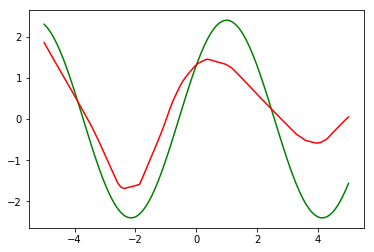

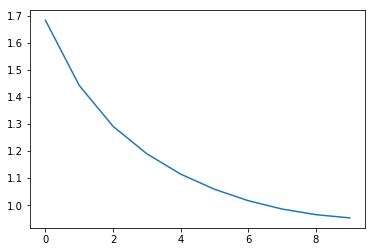

iteration: 30000
tensor([[ 0.0000],
        [ 0.4264],
        [-0.2431],
        [ 0.8044],
        [-0.1715],
        [ 0.8851],
        [-0.0498],
        [-0.1985],
        [ 0.6287],
        [-0.2294],
        [ 0.0581],
        [ 0.1012],
        [ 0.0922],
        [ 0.0000],
        [ 0.1375],
        [ 0.0101],
        [ 0.9894],
        [-0.5352],
        [-0.1988],
        [ 0.4708],
        [ 0.1048],
        [ 0.1647],
        [-0.2496],
        [-0.3628],
        [-0.0597],
        [ 0.0000],
        [-0.5651],
        [ 0.6435],
        [-0.1531],
        [-0.1457],
        [ 0.2719],
        [ 1.1530],
        [-0.3306],
        [ 0.0553],
        [ 0.0812],
        [ 0.0695],
        [-0.1030],
        [-0.1481],
        [-0.4016],
        [-0.1273]])
tensor([ 0.0000, -0.1490, -0.0973, -0.2284, -0.0666, -0.2717,  0.0114, -0.0780,
        -0.2005, -0.0917,  0.0232, -0.0171,  0.0276,  0.0000, -0.0156,  0.0233,
         0.0884,  0.1359,  0.0910,  0.0956,  0.0314, -0.0502, 

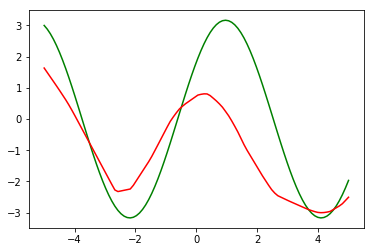

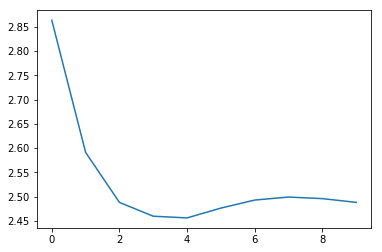

iteration: 35000
tensor([[ 0.0000],
        [-0.5586],
        [-0.1178],
        [-1.6171],
        [-0.2694],
        [-0.5629],
        [ 0.0820],
        [-0.2385],
        [-0.2840],
        [-0.2253],
        [ 0.0000],
        [-0.0507],
        [ 0.9864],
        [ 0.0000],
        [-0.1367],
        [ 0.1147],
        [ 0.7522],
        [ 0.2043],
        [ 0.1491],
        [ 0.5494],
        [ 1.1182],
        [ 0.2682],
        [-0.5173],
        [ 0.2498],
        [-0.0801],
        [ 0.0000],
        [ 0.1142],
        [-1.3927],
        [-0.0351],
        [-0.0413],
        [ 0.1205],
        [ 1.0487],
        [ 0.2948],
        [-0.3917],
        [ 0.8658],
        [ 0.8491],
        [ 0.1826],
        [ 0.1060],
        [ 0.3179],
        [ 0.2963]])
tensor([ 0.0000, -0.0727, -0.0549, -0.0131, -0.2739, -0.3824, -0.0166, -0.2401,
        -0.3523, -0.0835,  0.0000,  0.0647,  0.2294,  0.0000, -0.3253, -0.0417,
         0.2324, -0.0023, -0.0342,  0.1368,  0.2600, -0.1014, 

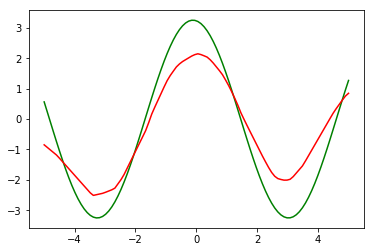

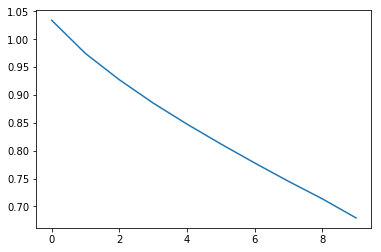

iteration: 40000
tensor([[ 0.0000],
        [-0.5327],
        [ 0.0801],
        [-1.6588],
        [ 0.1052],
        [-1.3061],
        [ 0.1369],
        [ 0.0754],
        [-0.7569],
        [-0.0063],
        [ 0.0000],
        [-0.1948],
        [ 1.2826],
        [ 0.0000],
        [-0.0095],
        [-0.0892],
        [-1.0929],
        [ 0.7473],
        [ 0.1188],
        [-0.4356],
        [ 0.9665],
        [-0.2062],
        [ 0.0521],
        [ 0.4100],
        [ 0.0000],
        [ 0.0000],
        [ 0.7780],
        [-1.2338],
        [ 0.0091],
        [ 0.0481],
        [-0.4058],
        [-1.1105],
        [ 0.3056],
        [-0.0785],
        [ 1.1395],
        [ 1.1393],
        [ 0.0103],
        [ 0.1329],
        [ 0.3642],
        [ 0.1761]])
tensor([ 0.0000,  0.2312,  0.0199,  0.5755,  0.1329,  0.4772, -0.0328,  0.1097,
         0.4216, -0.0111,  0.0000,  0.0307,  0.2730,  0.0000,  0.2532,  0.0265,
         0.0743, -0.1793, -0.0224, -0.0196,  0.1630,  0.0755, 

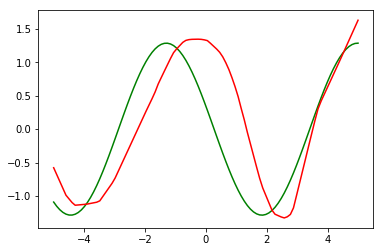

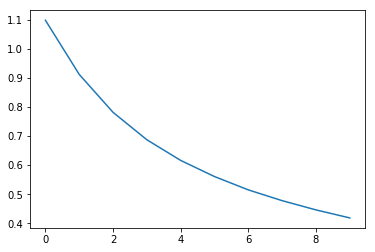

iteration: 45000
tensor([[ 0.0000],
        [ 0.6680],
        [-0.3711],
        [ 2.6060],
        [-0.0269],
        [ 1.9756],
        [ 0.0000],
        [-0.1164],
        [ 1.3832],
        [-0.2374],
        [ 0.0000],
        [ 0.2600],
        [-0.5038],
        [ 0.0000],
        [ 0.2736],
        [ 0.0801],
        [ 1.5065],
        [-1.2380],
        [-0.5028],
        [ 0.4543],
        [-0.5726],
        [ 0.3981],
        [-0.2760],
        [-0.7137],
        [ 0.0000],
        [ 0.0000],
        [-1.3842],
        [ 2.0058],
        [-0.3080],
        [-0.1614],
        [ 0.7460],
        [ 1.6907],
        [-0.6917],
        [ 0.2522],
        [-0.4517],
        [-0.4544],
        [-0.1560],
        [-0.0359],
        [-0.9361],
        [-0.2721]])
tensor([ 0.0000, -0.2118, -0.2817, -0.6883, -0.1654, -0.4770,  0.0000, -0.0665,
        -0.3524, -0.1911,  0.0000, -0.0382, -0.1224,  0.0000, -0.0682, -0.0241,
         0.0196,  0.3761,  0.1879,  0.1061, -0.1391,  0.0578, 

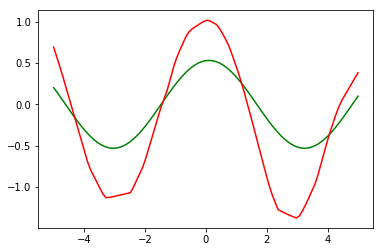

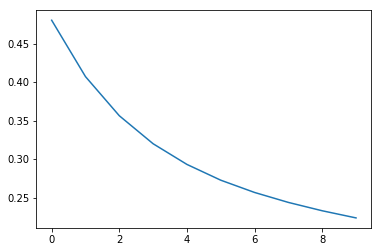

In [40]:
maml_model = Net()
maml_learning_alg = MAML()
train_data = DataGenerator("sine")
maml_learning_alg.train(maml_model, train_data)

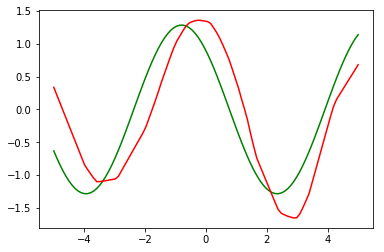

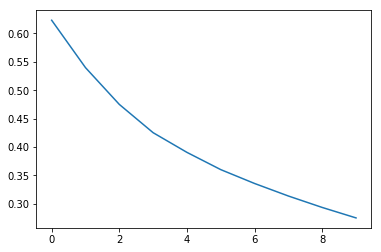

In [42]:
eval(maml_model)

In [48]:
class Experiment(MetaLearner):
    def __init__(self, lr_inner=0.01, lr_outer=0.001, sgd_steps_inner=10):
        super().__init__(False, lr_inner, lr_outer, sgd_steps_inner)
        self.average_weights = {}
        self.averager_size = 50
        self.test_tasks = []
    
    def init_averager(self, model):
        for name, param in model.named_parameters():
            self.average_weights[name] = torch.zeros_like(param)
        
    def load_averaged_weights(self, model):
        for name, param in model.named_parameters():
            param.data = self.average_weights[name]
        
    def train(self, model, train_data):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr_outer)
        self.init_grad(model)
        self.init_averager(model)
        
        for i, task in enumerate(train_data.shuffled_set()):
            self.test_tasks.append(task)
            inner_model = copy.deepcopy(model)
            inner_optim = torch.optim.SGD(inner_model.parameters(), lr=self.lr_inner)

            for _ in range(self.sgd_steps_inner):
                self.inner_train(inner_model, task, inner_optim)

            for name, param in inner_model.named_parameters():
                self.average_weights[name] = self.average_weights[name] + param/self.averager_size
                                  
            if i % self.averager_size == 0 and i>0:
                self.load_averaged_weights(model)
                
                for task in self.test_tasks:
                    x, y = task.mini_test_set()
                    predicted = model(x)
                    loss = F.mse_loss(predicted, y)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                
                self.test_tasks = []
                self.init_averager(model)
                
            if i % 5000 == 0:
                print("iteration:", i)
                eval(model)

iteration: 0


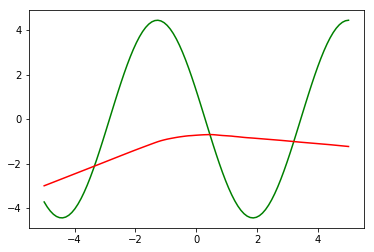

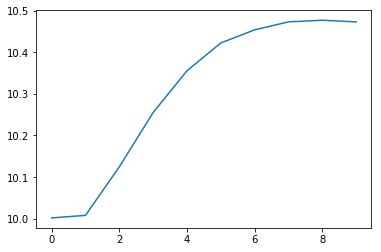

iteration: 5000


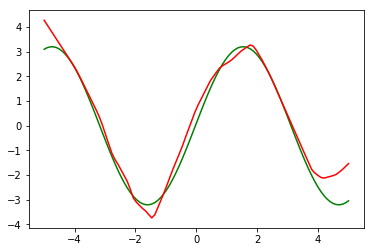

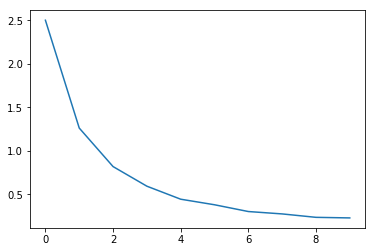

iteration: 10000


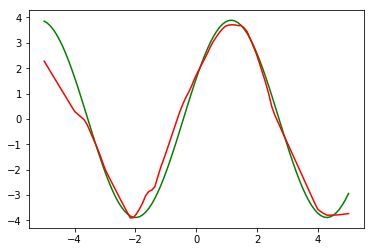

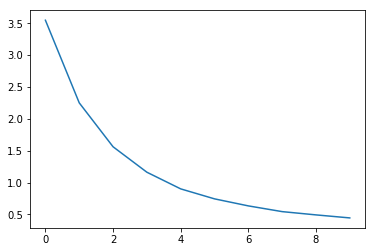

iteration: 15000


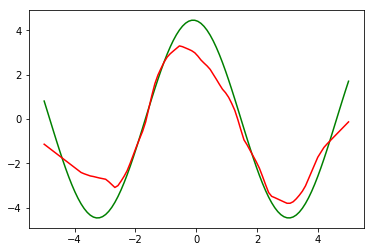

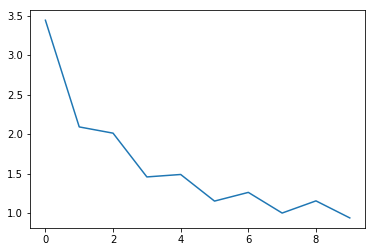

iteration: 20000


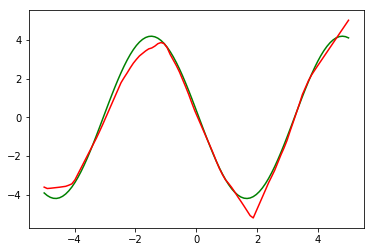

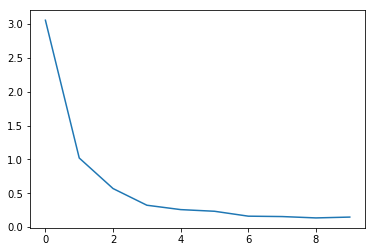

iteration: 25000


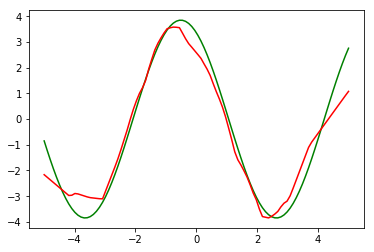

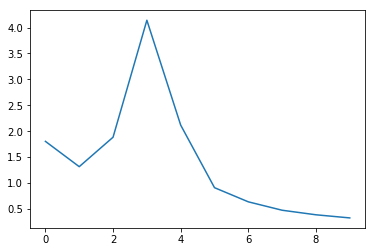

iteration: 30000


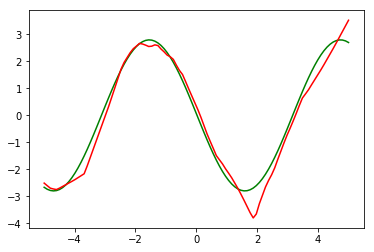

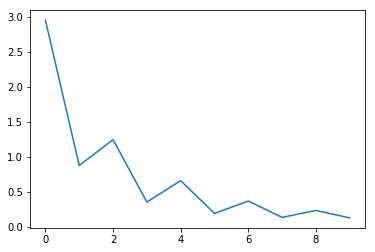

iteration: 35000


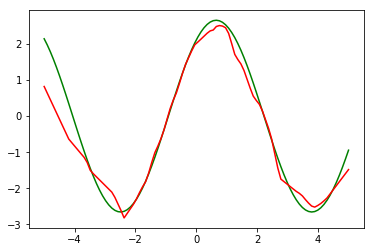

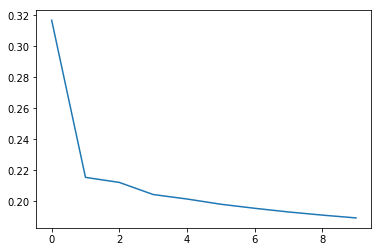

iteration: 40000


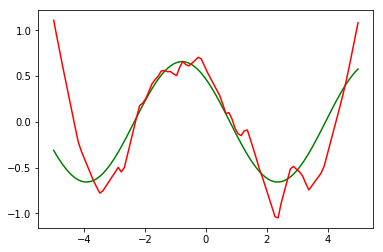

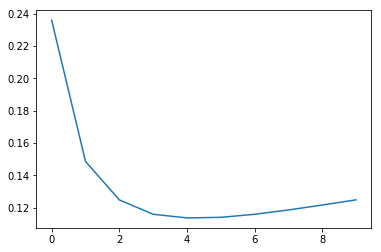

iteration: 45000


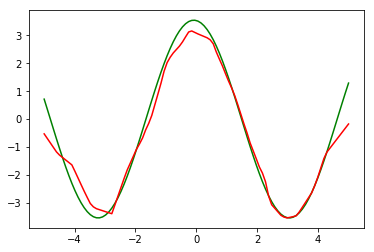

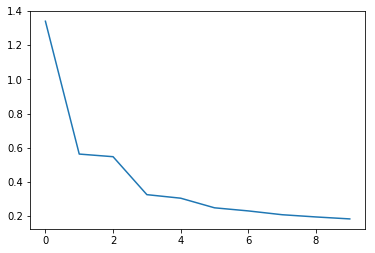

In [49]:
exp_model = Net()
exp_learning_alg = Experiment()
train_data = DataGenerator("sine")
exp_learning_alg.train(exp_model, train_data)

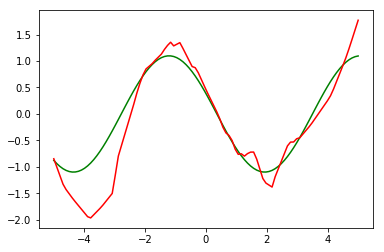

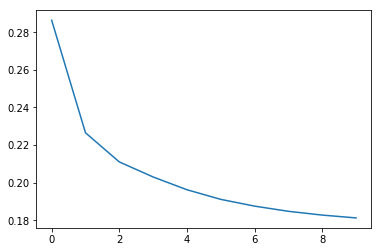

In [56]:
eval(exp_model)
torch.save(exp_model, 'experiment2.pt')